In [ ]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
# Copyright 2020, Xiaozhi Wang
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Finetuning the library models for multiple choice (Bert, Roberta, XLNet)."""


' Finetuning the library models for multiple choice (Bert, Roberta, XLNet).'

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 9.0 MB/s 
     |████████████████████████████████| 636 kB 39.8 MB/s 
     |████████████████████████████████| 895 kB 68.9 MB/s 
     |████████████████████████████████| 3.3 MB 77.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/w266/MAVEN')
sys.path.append('/content/drive/MyDrive/w266/MAVEN/baselines/DMBERT')
#!cp ./drive/MyDrive/w266/MAVEN/data ./data -r
#rm MAVEN -r

In [ ]:
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMultipleChoice,
    BertTokenizer,
    RobertaConfig,
    RobertaForMultipleChoice,
    RobertaTokenizer,
    XLNetConfig,
    XLNetForMultipleChoice,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
)
from utils_ee import convert_examples_to_features, processors
from sklearn.metrics import f1_score,precision_score,recall_score
from model import DMBERT

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter


In [ ]:
logger = logging.getLogger(__name__)

ALL_MODELS = "" #BCJ sum(
#    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, XLNetConfig, #RobertaConfig)), ()
#)

MODEL_CLASSES = {
    "bert": (BertConfig, DMBERT, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForMultipleChoice, XLNetTokenizer),
    "roberta": (RobertaConfig, RobertaForMultipleChoice, RobertaTokenizer),
}

def calculate_scores(preds, labels, dimE):
    positive_labels=list(range(1,dimE)) #assume 0 is NA
    pre = precision_score(labels, preds, labels=positive_labels, average='micro')
    recall = recall_score(labels, preds, labels=positive_labels, average='micro')
    f1 = f1_score(labels, preds, labels=positive_labels, average='micro')
    return pre, recall, f1

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


In [ ]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )
    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    best_dev_f1 = 0.0
    best_steps = 0
    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0])
    set_seed(args)  # Added here for reproductibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2]
                if args.model_type in ["bert", "xlnet"]
                else None,  # XLM don't use segment_ids
                "maskL": batch[3],
                "maskR": batch[4],
                "labels": batch[5],
            }
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:

                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        #for key, value in results.items():
                            #tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                        if results["eval_f1"] > best_dev_f1:
                            best_dev_f1 = results["eval_f1"]
                            best_steps = global_step
                            if args.do_test:
                                results_test = evaluate(args, model, tokenizer, test=True)
                                #for key, value in results_test.items():
                                    #tb_writer.add_scalar("test_{}".format(key), value, global_step)
                                logger.info(
                                    "test f1: %s, loss: %s, global steps: %s",
                                    str(results_test["eval_f1"]),
                                    str(results_test["eval_loss"]),
                                    str(global_step),
                                )
                    #tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    #tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logger.info(
                        "Average loss: %s at global step: %s",
                        str((tr_loss - logging_loss) / args.logging_steps),
                        str(global_step),
                    )
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    #add
                    basic=model.module if hasattr(model, "module") else model
                    bert_to_save = (basic.bert.module if hasattr(basic.bert, "module") else basic.bert)
                    tmp=os.path.join(output_dir,"bert")
                    if not os.path.exists(tmp):
                        os.makedirs(tmp)
                    bert_to_save.save_pretrained(tmp)
                    #add end
                    tokenizer.save_vocabulary(output_dir)
                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    #if args.local_rank in [-1, 0]:
        #tb_writer.close()

    return global_step, tr_loss / global_step, best_steps


In [ ]:
def evaluate(args, model, tokenizer, prefix="", test=False, infer=True):
    eval_task_names = (args.task_name,)
    eval_outputs_dirs = (args.output_dir,)

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = load_and_cache_examples(args, eval_task, tokenizer, evaluate=not test, test=test)

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

        # multi-gpu evaluate
        #if args.n_gpu > 1:
            #print("?????",args.n_gpu)
            #model = torch.nn.DataParallel(model)

        # Eval!
        logger.info("***** Running evaluation {} *****".format(prefix))
        logger.info("  Num examples = %d", len(eval_dataset))
        logger.info("  Batch size = %d", args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2]
                    if args.model_type in ["bert", "xlnet"]
                    else None,  # XLM don't use segment_ids
                    "maskL": batch[3],
                    "maskR": batch[4],
                    "labels": batch[5],
                }
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        preds_full = preds
        preds = np.argmax(preds, axis=1)
        #print(eval_task)
        #print(processors[eval_task])
        precision, recall, f1 = calculate_scores(preds, out_label_ids, len(processors[eval_task]().get_labels()))
        if infer:
            np.save(os.path.join(eval_output_dir, str(prefix)+"_preds_full.npy"),preds_full)
            np.save(os.path.join(eval_output_dir, str(prefix)+"_preds.npy"),preds)
            np.save(os.path.join(eval_output_dir, str(prefix)+"_trues.npy"),out_label_ids)
            
        result = {"eval_p": precision, "eval_recall": recall, "eval_f1": f1, "eval_loss": eval_loss}
        results.update(result)

        output_eval_file = os.path.join(eval_output_dir, "is_test_" + str(test).lower() + "_eval_results.txt")

        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(str(prefix) + " is test:" + str(test)))
            writer.write("model           =%s\n" % str(args.model_name_or_path))
            writer.write(
                "total batch size=%d\n"
                % (
                    args.per_gpu_train_batch_size
                    * args.gradient_accumulation_steps
                    * (torch.distributed.get_world_size() if args.local_rank != -1 else 1)
                )
            )
            writer.write("train num epochs=%d\n" % args.num_train_epochs)
            writer.write("fp16            =%s\n" % args.fp16)
            writer.write("max seq length  =%d\n" % args.max_seq_length)
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))
    return results


In [ ]:
def load_and_cache_examples(args, task, tokenizer, evaluate=False, test=False):
    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    processor = processors[task]()
    # Load data features from cache or dataset file
    if evaluate:
        cached_mode = "dev"
    elif test:
        cached_mode = "test"
    else:
        cached_mode = "train"
    assert not (evaluate and test)

    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            cached_mode,
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_length),
            str(task),
        ),
    )

    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        label_list = processor.get_labels()
        if evaluate:
            examples = processor.get_dev_examples(args.data_dir)
        elif test:
            examples = processor.get_test_examples(args.data_dir)
        else:
            examples = processor.get_train_examples(args.data_dir)
        logger.info("Training number: %s", str(len(examples)))
        features = convert_examples_to_features(
            examples,
            label_list,
            args.max_seq_length,
            tokenizer,
            pad_on_left=bool(args.model_type in ["xlnet"]),  # pad on the left for xlnet
            pad_token_segment_id=4 if args.model_type in ["xlnet"] else 0,
        )
        if args.local_rank in [-1, 0]:
            logger.info("Saving features into cached file %s", cached_features_file)
            torch.save(features[:idx], cached_features_file)

    logger.info("Num records = %s", str(len(features)))

    if args.local_rank == 0:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    # Convert to Tensors and build dataset
    logger.info("Convert to Tensors and build dataset")
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_maskL = torch.tensor([f.maskL for f in features], dtype=torch.float)
    all_maskR = torch.tensor([f.maskR for f in features], dtype=torch.float)
    all_label_ids = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_maskL, all_maskR, all_label_ids)
    return dataset


In [ ]:
def process_args(args_in):
    parser = argparse.ArgumentParser()

    # Required parameters
    parser.add_argument(
        "--data_dir",
        default=None,
        type=str,
        #required=True,
        help="The input data dir. Should contain the .tsv files (or other data files) for the task.",
    )
    parser.add_argument(
        "--model_type",
        default=None,
        type=str,
        #required=True,
        help="Model type selected in the list: " + ", ".join(MODEL_CLASSES.keys()),
    )
    parser.add_argument(
        "--model_name_or_path",
        default=None,
        type=str,
        #required=True,
        help="Path to pre-trained model or shortcut name selected in the list: " + ", ".join(ALL_MODELS),
    )
    parser.add_argument(
        "--task_name",
        default=None,
        type=str,
        #required=True,
        help="The name of the task to train selected in the list: " + ", ".join(processors.keys()),
    )
    parser.add_argument(
        "--output_dir",
        default=None,
        type=str,
        #required=True,
        help="The output directory where the model predictions and checkpoints will be written.",
    )

    # Other parameters
    parser.add_argument(
        "--config_name", default="", type=str, help="Pretrained config name or path if not the same as model_name"
    )
    parser.add_argument(
        "--tokenizer_name",
        default="",
        type=str,
        help="Pretrained tokenizer name or path if not the same as model_name",
    )
    parser.add_argument(
        "--cache_dir",
        default="",
        type=str,
        help="Where do you want to store the pre-trained models downloaded from s3",
    )
    parser.add_argument(
        "--max_seq_length",
        default=128,
        type=int,
        help="The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument("--do_train", action="store_true", help="Whether to run training.")
    parser.add_argument("--do_eval", action="store_true", help="Whether to run eval on the dev set.")
    parser.add_argument("--do_test", action="store_true", help="Whether to run test on the test set")
    parser.add_argument("--do_infer", action="store_true", help="Whether to run inference on the test set")
    parser.add_argument(
        "--evaluate_during_training", action="store_true", help="Run evaluation during training at each logging step."
    )
    parser.add_argument(
        "--do_lower_case", action="store_true", help="Set this flag if you are using an uncased model."
    )

    parser.add_argument("--per_gpu_train_batch_size", default=8, type=int, help="Batch size per GPU/CPU for training.")
    parser.add_argument(
        "--per_gpu_eval_batch_size", default=8, type=int, help="Batch size per GPU/CPU for evaluation."
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight deay if we apply some.")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument(
        "--num_train_epochs", default=3.0, type=float, help="Total number of training epochs to perform."
    )
    parser.add_argument(
        "--max_steps",
        default=-1,
        type=int,
        help="If > 0: set total number of training steps to perform. Override num_train_epochs.",
    )
    parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")

    parser.add_argument("--logging_steps", type=int, default=500, help="Log every X updates steps.")
    parser.add_argument("--save_steps", type=int, default=500, help="Save checkpoint every X updates steps.")
    parser.add_argument(
        "--eval_all_checkpoints",
        action="store_true",
        help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",
    )
    parser.add_argument("--no_cuda", action="store_true", help="Avoid using CUDA when available")
    parser.add_argument(
        "--overwrite_output_dir", action="store_true", help="Overwrite the content of the output directory"
    )
    parser.add_argument(
        "--overwrite_cache", action="store_true", help="Overwrite the cached training and evaluation sets"
    )
    parser.add_argument("--seed", type=int, default=42, help="random seed for initialization")

    parser.add_argument(
        "--fp16",
        action="store_true",
        help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit",
    )
    parser.add_argument(
        "--fp16_opt_level",
        type=str,
        default="O1",
        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
        "See details at https://nvidia.github.io/apex/amp.html",
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument("--server_ip", type=str, default="", help="For distant debugging.")
    parser.add_argument("--server_port", type=str, default="", help="For distant debugging.")
    args = parser.parse_args(args=args_in) # BCJ added args=args_in for use in notebook
    print(args) # BCJ
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and args.cache_dir == None
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup distant debugging if needed
    if args.server_ip and args.server_port:
        # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
        import ptvsd

        print("Waiting for debugger attach")
        ptvsd.enable_attach(address=(args.server_ip, args.server_port), redirect_output=True)
        ptvsd.wait_for_attach()

    # Setup CUDA, GPU & distributed training
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        args.n_gpu = 0 if args.no_cuda else torch.cuda.device_count()
        print("using CPU")
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        torch.distributed.init_process_group(backend="nccl")
        args.n_gpu = 1
        print("using GPU:", args.n_gpu, device)
    args.device = device

    return args

In [ ]:
def main(args_in): # BCJ added args=args_in for use in notebook instead of shell script
    args = process_args(args_in)

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        args.device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    # Prepare GLUE task
    args.task_name = args.task_name.lower()
    if args.task_name not in processors:
        raise ValueError("Task not found: %s" % (args.task_name))
    processor = processors[args.task_name]()
    label_list = processor.get_labels()
    num_labels = len(label_list)

    # Load pretrained model and tokenizer
    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    args.model_type = args.model_type.lower()
    config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
    config = config_class.from_pretrained(
        args.config_name if args.config_name else args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=args.task_name,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    tokenizer = tokenizer_class.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
        do_lower_case=args.do_lower_case,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    model = model_class.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )

    if args.local_rank == 0:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)
    best_steps = 0

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, args.task_name, tokenizer, evaluate=False)
        global_step, tr_loss, best_steps = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    if args.do_train and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
        # Create output directory if needed
        if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(args.output_dir)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = model_class.from_pretrained(args.output_dir)
        tokenizer = tokenizer_class.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        if not args.do_train:
            args.output_dir = args.model_name_or_path
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = model_class.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    if args.do_test and args.local_rank in [-1, 0]:
        if not args.do_train:
            args.output_dir = args.model_name_or_path
        checkpoints = [args.output_dir]
        # if args.eval_all_checkpoints: # can not use this to do test!!
        #     checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + '/**/' + WEIGHTS_NAME, recursive=True)))
        #     logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = model_class.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, prefix=prefix, test=True)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)
    if args.do_infer and args.local_rank in [-1, 0]:
        if not args.do_train:
            args.output_dir = args.model_name_or_path
        checkpoints = [args.output_dir]
        logger.info("Do inference for the checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""
            model = model_class.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, prefix=prefix, test=True, infer=True)
            #result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            #results.update(result)

    if best_steps:
        logger.info("best steps of eval f1 is the following checkpoints: %s", best_steps)
    return results


In [ ]:
if True: # training
  results = main(args_in=['--output_dir', './drive/MyDrive/w266/MAVEN/runs_aug2',
              '--data_dir','./drive/MyDrive/w266/MAVEN/data',
              '--model_type', 'bert',
              '--model_name_or_path', 'bert-base-uncased', # DEFAULT
              #'--model_name_or_path', './drive/MyDrive/w266/MAVEN/runs_aug2/checkpoint-40000',
              '--task_name', 'maven',
              '--do_train',
              '--do_eval',
              #'--evaluate_during_training',
              '--do_lower_case',
              '--save_steps', '30000',
              '--per_gpu_train_batch_size','42',
              '--per_gpu_eval_batch_size', '42',
              '--gradient_accumulation_steps', '3',
              '--num_train_epochs','5' # 5 is default
            ])

07/25/2021 02:28:04 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False


Namespace(adam_epsilon=1e-08, cache_dir='', config_name='', data_dir='./drive/MyDrive/w266/MAVEN/data', do_eval=True, do_infer=False, do_lower_case=True, do_test=False, do_train=True, eval_all_checkpoints=False, evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=3, learning_rate=5e-05, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_seq_length=128, max_steps=-1, model_name_or_path='bert-base-uncased', model_type='bert', no_cuda=False, num_train_epochs=5.0, output_dir='./drive/MyDrive/w266/MAVEN/runs_aug2', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=42, per_gpu_train_batch_size=42, save_steps=30000, seed=42, server_ip='', server_port='', task_name='maven', tokenizer_name='', warmup_steps=0, weight_decay=0.0)
using CPU


07/25/2021 02:28:05 - INFO - filelock -   Lock 140086543124624 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


07/25/2021 02:28:05 - INFO - filelock -   Lock 140086543124624 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


07/25/2021 02:28:06 - INFO - filelock -   Lock 140086543351120 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


07/25/2021 02:28:06 - INFO - filelock -   Lock 140086543351120 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


07/25/2021 02:28:07 - INFO - filelock -   Lock 140086543351120 acquired on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


07/25/2021 02:28:07 - INFO - filelock -   Lock 140086543351120 released on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


07/25/2021 02:28:08 - INFO - filelock -   Lock 140086542991760 acquired on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


07/25/2021 02:28:08 - INFO - filelock -   Lock 140086542991760 released on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


07/25/2021 02:28:09 - INFO - filelock -   Lock 140086396503632 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


07/25/2021 02:28:18 - INFO - filelock -   Lock 140086396503632 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing DMBERT: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing DMBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DMBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DMBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You s

07/25/2021 02:28:36 - INFO - utils_ee -   Writing example 0 of 1519542
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
07/25/2021 02:30:22 - INFO - utils_ee -   Writing example 100000 of 1519542
07/25/2021 02:32:04 - INFO - utils_ee -   Writing example 200000 of 1519542
07/25/2021 02:33:49 - INFO - utils_ee -   Writing example 300000 of 1519542
07/25/2021 02:35:33 - INFO - utils_ee -   Writing example 400000 of 1519542
07/25/2021 02:37:16 - INFO - utils_ee -   Writing example 500000 of 1519542
07/25/2021 02:39:03 - INFO - utils_ee -   Writing example 600000 of 1519542
07/25/2021 02:40:47 - INFO - utils_ee -   Writing example 700000 of 1519542
07/25/2021 02:42:27 - IN

07/25/2021 02:56:15 - INFO - __main__ -   Saving features into cached file ./drive/MyDrive/w266/MAVEN/data/cached_train_bert-base-uncased_128_maven_2
07/25/2021 02:58:02 - INFO - __main__ -   Saving features into cached file ./drive/MyDrive/w266/MAVEN/data/cached_train_bert-base-uncased_128_maven_3
07/25/2021 03:00:24 - INFO - __main__ -   Num records = 1519542
07/25/2021 03:00:24 - INFO - __main__ -   Convert to Tensors and build dataset
07/25/2021 03:03:21 - INFO - __main__ -   ***** Running training *****
07/25/2021 03:03:21 - INFO - __main__ -     Num examples = 1519542
07/25/2021 03:03:21 - INFO - __main__ -     Num Epochs = 5
07/25/2021 03:03:21 - INFO - __main__ -     Instantaneous batch size per GPU = 42
07/25/2021 03:03:21 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 126
07/25/2021 03:03:21 - INFO - __main__ -     Gradient Accumulation steps = 3
07/25/2021 03:03:21 - INFO - __main__ -     Total optimization steps = 60300


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
07/25/2021 03:15:24 - INFO - __main__ -   Average loss: 0.7930807721018791 at global step: 500
07/25/2021 03:27:28 - INFO - __main__ -   Average loss: 0.4952382749971002 at global step: 1000
07/25/2021 03:39:31 - INFO - __main__ -   Average loss: 0.40670620182156564 at global step: 1500
07/25/2021 03:51:35 - INFO - __main__ -   Average loss: 0.3691722531877458 at global step: 2000
07/25/2021 04:03:39 - INFO - __main__ -   Average loss: 0.3500326024289243 at global step: 2500
07/25/2021 04:15:43 - INFO - __main__ -   Average loss: 0.33412676110561007 at global step: 3000
07/25/2021 04:27:48

07/25/2021 08:05:00 - INFO - __main__ -   Average loss: 0.1905261359606884 at global step: 12500
07/25/2021 08:17:03 - INFO - __main__ -   Average loss: 0.17231963451381307 at global step: 13000
07/25/2021 08:29:07 - INFO - __main__ -   Average loss: 0.1760242048703876 at global step: 13500
07/25/2021 08:41:10 - INFO - __main__ -   Average loss: 0.17383716330246535 at global step: 14000
07/25/2021 08:53:14 - INFO - __main__ -   Average loss: 0.1709384337490701 at global step: 14500
07/25/2021 09:05:17 - INFO - __main__ -   Average loss: 0.16939003488323578 at global step: 15000
07/25/2021 09:17:20 - INFO - __main__ -   Average loss: 0.17471265489837243 at global step: 15500
07/25/2021 09:29:24 - INFO - __main__ -   Average loss: 0.17328288798147695 at global step: 16000
07/25/2021 09:41:28 - INFO - __main__ -   Average loss: 0.16724806156948763 at global step: 16500
07/25/2021 09:53:31 - INFO - __main__ -   Average loss: 0.16369851584585557 at global step: 17000
07/25/2021 10:05:34 - I

07/25/2021 12:54:32 - INFO - __main__ -   Average loss: 0.09354791748931347 at global step: 24500
07/25/2021 13:06:37 - INFO - __main__ -   Average loss: 0.07887535922171991 at global step: 25000
07/25/2021 13:18:41 - INFO - __main__ -   Average loss: 0.07741991982381297 at global step: 25500
07/25/2021 13:30:45 - INFO - __main__ -   Average loss: 0.07933266026361525 at global step: 26000
07/25/2021 13:42:49 - INFO - __main__ -   Average loss: 0.07547060127749865 at global step: 26500
07/25/2021 13:54:53 - INFO - __main__ -   Average loss: 0.07730580133212789 at global step: 27000
07/25/2021 14:06:57 - INFO - __main__ -   Average loss: 0.07459385410781397 at global step: 27500
07/25/2021 14:19:01 - INFO - __main__ -   Average loss: 0.07432255402718875 at global step: 28000
07/25/2021 14:31:05 - INFO - __main__ -   Average loss: 0.07200432853093662 at global step: 28500
07/25/2021 14:43:08 - INFO - __main__ -   Average loss: 0.07086522651949781 at global step: 29000
07/25/2021 14:55:12 

07/25/2021 17:43:56 - INFO - __main__ -   Average loss: 0.03925858389345012 at global step: 36500
07/25/2021 17:55:58 - INFO - __main__ -   Average loss: 0.03156223163057985 at global step: 37000
07/25/2021 18:08:01 - INFO - __main__ -   Average loss: 0.02591148555253858 at global step: 37500
07/25/2021 18:20:04 - INFO - __main__ -   Average loss: 0.02839680104814033 at global step: 38000
07/25/2021 18:32:06 - INFO - __main__ -   Average loss: 0.026427982007342508 at global step: 38500
07/25/2021 18:44:09 - INFO - __main__ -   Average loss: 0.02913672676995884 at global step: 39000
07/25/2021 18:56:11 - INFO - __main__ -   Average loss: 0.028071146085801957 at global step: 39500
07/25/2021 19:08:13 - INFO - __main__ -   Average loss: 0.028636375245292583 at global step: 40000
07/25/2021 19:20:15 - INFO - __main__ -   Average loss: 0.026392792953305617 at global step: 40500
07/25/2021 19:32:17 - INFO - __main__ -   Average loss: 0.026644878484010405 at global step: 41000
07/25/2021 19:4

In [ ]:
if False: # dev data
  results = main(args_in=['--output_dir', './drive/MyDrive/w266/MAVEN/runs_aug2',
              '--data_dir','./drive/MyDrive/w266/MAVEN/data',
              '--model_type', 'bert',
              '--model_name_or_path', './drive/MyDrive/w266/MAVEN/runs_aug2', # checkpoint
              '--task_name', 'maven',
              '--do_eval',
              '--do_lower_case',
              '--save_steps', '20000',
              '--per_gpu_train_batch_size','42',
              '--per_gpu_eval_batch_size', '42',
              '--gradient_accumulation_steps', '3',
              '--num_train_epochs','5'
            ])

07/23/2021 20:20:47 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False


Namespace(adam_epsilon=1e-08, cache_dir='', config_name='', data_dir='./drive/MyDrive/w266/MAVEN/data', do_eval=True, do_infer=False, do_lower_case=True, do_test=False, do_train=False, eval_all_checkpoints=False, evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=3, learning_rate=5e-05, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_seq_length=128, max_steps=-1, model_name_or_path='./drive/MyDrive/w266/MAVEN/runs_aug1', model_type='bert', no_cuda=False, num_train_epochs=5.0, output_dir='./drive/MyDrive/w266/MAVEN/tests_aug1', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=42, per_gpu_train_batch_size=42, save_steps=20000, seed=42, server_ip='', server_port='', task_name='maven', tokenizer_name='', warmup_steps=0, weight_decay=0.0)
using CPU


07/23/2021 20:21:01 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, cache_dir='', config_name='', data_dir='./drive/MyDrive/w266/MAVEN/data', device=device(type='cuda', index=0), do_eval=True, do_infer=False, do_lower_case=True, do_test=False, do_train=False, eval_all_checkpoints=False, evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=3, learning_rate=5e-05, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_seq_length=128, max_steps=-1, model_name_or_path='./drive/MyDrive/w266/MAVEN/runs_aug1', model_type='bert', n_gpu=1, no_cuda=False, num_train_epochs=5.0, output_dir='./drive/MyDrive/w266/MAVEN/tests_aug1', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=42, per_gpu_train_batch_size=42, save_steps=20000, seed=42, server_ip='', server_port='', task_name='maven', tokenizer_name='', warmup_steps=0, weight_decay=0.0)
07/23/2021 20:21:01 - INFO - __main__ -   Evaluate the follo

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


07/23/2021 20:25:30 - INFO - __main__ -   ***** Eval results  is test:False *****
07/23/2021 20:25:30 - INFO - __main__ -     eval_f1 = 0.7059178592087724
07/23/2021 20:25:30 - INFO - __main__ -     eval_loss = 0.3730894391536114
07/23/2021 20:25:30 - INFO - __main__ -     eval_p = 0.6728676223809752
07/23/2021 20:25:30 - INFO - __main__ -     eval_recall = 0.742382564536606


In [ ]:
if False: # test data - for inference submission
  results = main(args_in=['--output_dir', './drive/MyDrive/w266/MAVEN/infers',
              '--data_dir','./drive/MyDrive/w266/MAVEN/data',
              '--model_type', 'bert',
              '--model_name_or_path', './drive/MyDrive/w266/MAVEN/runs/checkpoint-15000', # checkpoint
              '--task_name', 'maven_infer',
              '--do_infer',
              '--do_lower_case',
              '--save_steps', '20000',
              '--per_gpu_train_batch_size','42',
              '--per_gpu_eval_batch_size', '42',
              '--gradient_accumulation_steps', '3',
              '--num_train_epochs','5'
            ])

In [ ]:
results

{'eval_f1_': 0.6606361978060422,
 'eval_loss_': 0.39050456698128405,
 'eval_p_': 0.6260478332938669,
 'eval_recall_': 0.6992699957680915}

In [1]:
import numpy as np
y_pred_full = np.load('/content/drive/MyDrive/w266/MAVEN/runs_baseline/checkpoint-15000/checkpoint-15000_preds_full.npy')
y_pred = np.load('/content/drive/MyDrive/w266/MAVEN/runs_baseline/checkpoint-15000/checkpoint-15000_preds.npy')
y_true = np.load('/content/drive/MyDrive/w266/MAVEN/runs_baseline/checkpoint-15000/checkpoint-15000_trues.npy')
#print(blah.shape)
print(y_pred[:10])
print(y_true[:10])

[ 68 146   7  34  97  16  41  99 129 139]
[ 68 146   7  51  97  16  41  99 129 139]


In [2]:
#y_pred_full[:1]

In [133]:
# a) Determine the number of samples where 
#         - the predicted label was wrong
#         - the true value was in the top 3 predicted labels
#         - the difference between the top 2 predictions was < 25%
#
# b) Determine the deviation between the top 2 predictions for 
#    each incorrectly predicted label

import torch
cnt = 0
incorrect_in_top_preds=0
rng = []
#for idx in range(200):
for idx in range(len(y_pred)):
  if y_pred[idx] != y_true[idx]:
    cnt+=1
    #continue
    samp = y_pred_full[idx]
    top = samp.argsort()[-3:]
    diff = (samp[top[-1]] - samp[top[-2]]) / samp[top[-1]]
    if diff < 1.25:
      #continue
      if y_true[idx] in top:
        rng.append(diff)
        incorrect_in_top_preds+=1
        #print(idx,y_true[idx],y_pred[idx],labels[top], top, samp[top])
#print(rng)
print(incorrect_in_top_preds)

9058


In [134]:
incorrect_in_top_preds/len(y_pred)

0.09186333073030233

In [135]:
# pct of all samples that are None
len(y_true[y_true==0])/len(y_true)

0.808281695283105

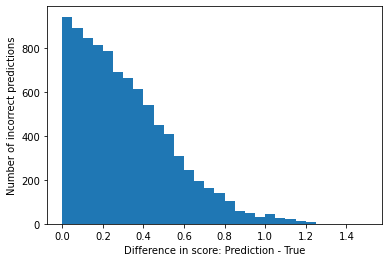

In [137]:
import matplotlib.pyplot as plt
plt.hist(rng,bins=30,range=(0,1.5))
plt.xlabel('Difference in score: Prediction - True')
plt.ylabel('Number of incorrect predictions')
plt.show()

4579


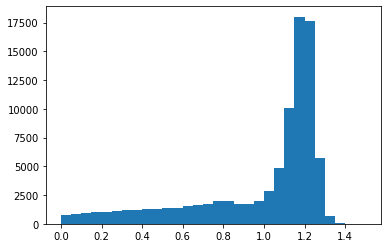

In [5]:
# Determine the deviation between the top 2 predictions for 
#    each correctly predicted label

cnt = 0
cnt2=0
rng = []
for idx in range(len(y_pred)):
  if y_pred[idx] == y_true[idx]:
    cnt+=1
    samp = y_pred_full[idx]
    top = samp.argsort()[-3:]
    diff = (samp[top[-1]] - samp[top[-2]]) / samp[top[-1]]
    rng.append(diff)
    if diff < .25:
      if y_true[idx] in top:
        cnt2+=1
print(cnt2)
plt.hist(rng,bins=30,range=(0,1.5))
plt.show()

In [6]:
#np.unique(y_pred)
#np.unique(y_true)

In [7]:
np.set_printoptions(suppress=True, precision=3)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

In [8]:
import pandas as pd
labels = np.array(["None", "Know", "Warning", "Catastrophe", "Placing", "Causation", "Arriving", "Sending", "Protest", "Preventing_or_letting", "Motion", "Damaging", "Destroying", "Death", "Perception_active", "Presence", "Influence", "Receiving", "Check", "Hostile_encounter", "Killing", "Conquering", "Releasing", "Attack", "Earnings_and_losses", "Choosing", "Traveling", "Recovering", "Using", "Coming_to_be", "Cause_to_be_included", "Process_start", "Change_event_time", "Reporting", "Bodily_harm", "Suspicion", "Statement", "Cause_change_of_position_on_a_scale", "Coming_to_believe", "Expressing_publicly", "Request", "Control", "Supporting", "Defending", "Building", "Military_operation", "Self_motion", "GetReady", "Forming_relationships", "Becoming_a_member", "Action", "Removing", "Surrendering", "Agree_or_refuse_to_act", "Participation", "Deciding", "Education_teaching", "Emptying", "Getting", "Besieging", "Creating", "Process_end", "Body_movement", "Expansion", "Telling", "Change", "Legal_rulings", "Bearing_arms", "Giving", "Name_conferral", "Arranging", "Use_firearm", "Committing_crime", "Assistance", "Surrounding", "Quarreling", "Expend_resource", "Motion_directional", "Bringing", "Communication", "Containing", "Manufacturing", "Social_event", "Robbery", "Competition", "Writing", "Rescuing", "Judgment_communication", "Change_tool", "Hold", "Being_in_operation", "Recording", "Carry_goods", "Cost", "Departing", "GiveUp", "Change_of_leadership", "Escaping", "Aiming", "Hindering", "Preserving", "Create_artwork", "Openness", "Connect", "Reveal_secret", "Response", "Scrutiny", "Lighting", "Criminal_investigation", "Hiding_objects", "Confronting_problem", "Renting", "Breathing", "Patrolling", "Arrest", "Convincing", "Commerce_sell", "Cure", "Temporary_stay", "Dispersal", "Collaboration", "Extradition", "Change_sentiment", "Commitment", "Commerce_pay", "Filling", "Becoming", "Achieve", "Practice", "Cause_change_of_strength", "Supply", "Cause_to_amalgamate", "Scouring", "Violence", "Reforming_a_system", "Come_together", "Wearing", "Cause_to_make_progress", "Legality", "Employment", "Rite", "Publishing", "Adducing", "Exchange", "Ratification", "Sign_agreement", "Commerce_buy", "Imposing_obligation", "Rewards_and_punishments", "Institutionalization", "Testing", "Ingestion", "Labeling", "Kidnapping", "Submitting_documents", "Prison", "Justifying", "Emergency", "Terrorism", "Vocalizations", "Risk", "Resolve_problem", "Revenge", "Limiting", "Research", "Having_or_lacking_access", "Theft", "Incident", "Award"])
pd_labels = pd.DataFrame(labels)
#labels.shape

In [9]:
# Top N least accurate predictions
import pandas as pd
cm_good = pd.DataFrame(np.column_stack([labels, cm.diagonal(), cm_norm.diagonal(), [x for x in range(169)]]),
                       columns = ['Event_Type','Num_Examples','Accuracy','Index'])
cm_good['Accuracy'] = cm_good['Accuracy'].astype(float).round(3)
cm_good.sort_values(by='Accuracy').head(20)

,Event_Type,Num_Examples,Accuracy,Index
132,Scouring,0,0.000,132
144,Ratification,0,0.000,144
167,Incident,0,0.000,167
88,Change_tool,0,0.000,88
157,Emergency,0,0.000,157
160,Risk,0,0.000,160
62,Body_movement,1,0.040,62
140,Rite,1,0.091,140
165,Having_or_lacking_access,2,0.105,165
72,Committing_crime,9,0.220,72


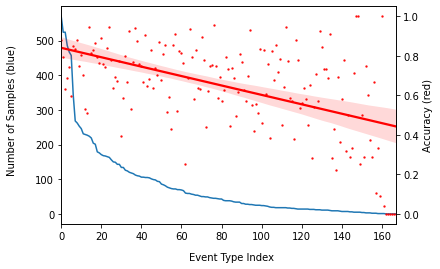

In [80]:
import seaborn as sns
cm_good.Num_Examples = cm_good.Num_Examples.astype(int)
p1 = cm_good.sort_values(by='Num_Examples', ascending=False)[1:]
x1 = range(168)
good = pd.DataFrame(np.column_stack([x1, p1.Num_Examples, p1.Accuracy]),
                       columns = ['Event_Index','Num_Examples','Accuracy (red)'])

fig, ax = plt.subplots()
axes = [ax, ax.twinx()]
axes[0].plot(x1, p1.Num_Examples)
fig.text(0,0.3,'Number of Samples (blue)', rotation='vertical')
fig.text(0.42,0,'Event Type Index')
sns.regplot(x='Event_Index',y='Accuracy (red)', data=good, fit_reg=True, color='red', scatter_kws={'s':2}) 
plt.show()



In [81]:
cm_good.sort_values(by='Num_Examples', ascending=False)[:10]

,Event_Type,Num_Examples,Accuracy,Index
0,None,74497,0.935,0
31,Process_start,570,0.881,31
5,Causation,524,0.795,5
3,Catastrophe,524,0.632,3
84,Competition,486,0.687,84
23,Attack,467,0.741,23
19,Hostile_encounter,457,0.598,19
20,Killing,343,0.847,20
21,Conquering,268,0.832,21
29,Coming_to_be,262,0.879,29


In [82]:
# Top N most accurate
cm_good.sort_values(by='Accuracy', ascending=False).head(20)

,Event_Type,Num_Examples,Accuracy,Index
112,Breathing,1,1.000,112
159,Vocalizations,5,1.000,159
35,Suspicion,5,1.000,35
52,Surrendering,45,0.957,52
30,Cause_to_be_included,163,0.948,30
93,Cost,18,0.947,93
126,Becoming,224,0.945,126
33,Reporting,112,0.941,33
141,Publishing,59,0.937,141
0,None,74497,0.935,0


In [86]:
trues_idx = []
falses_idx = []
cnts = []
norms = []
for i in range(169):
  for j in range(i):
    if i != j:
      trues_idx.append(i)
      falses_idx.append(j)
      cnts.append(cm[i,j])
      norms.append(cm_norm[i,j])

cm_poor = pd.DataFrame(np.column_stack([trues_idx, falses_idx, cnts, norms]),
                       columns = ['True_Index','Pred_Index','Num_Examples','Accuracy'])
cm_poor['Accuracy'] = cm_poor['Accuracy'].astype(float).round(3)
cm_poor['Num_Examples'] = cm_poor['Num_Examples'].astype(int)
cm_poor = cm_poor.join(pd_labels, on='True_Index')
cm_poor = cm_poor.rename({0:'True_Label'}, axis=1)
cm_poor = cm_poor.join(pd_labels, on='Pred_Index')
cm_poor = cm_poor.rename({0:'Pred_Label'}, axis=1)

In [98]:
cm_poor_top = cm_poor[cm_poor['Num_Examples']>=0].sort_values(by='Num_Examples', ascending=False).head(169)[['Num_Examples', 'True_Label', 'Pred_Label']]

In [105]:
len(np.unique(cm_poor_top[cm_poor_top['Pred_Label']=='None'].True_Label))

107

In [107]:
len(cm_poor_top.True_Label)

169

In [101]:
107/168

0.6369047619047619

In [100]:
cm_poor_top[:50]

,Num_Examples,True_Label,Pred_Label
3,262,Catastrophe,None
171,242,Hostile_encounter,None
3321,195,Social_event,None
3486,189,Competition,None
990,128,Military_operation,None
45,86,Motion,None
1035,86,Self_motion,None
253,84,Attack,None
10,75,Causation,None
1830,60,Process_end,None


In [ ]:
#!nvidia-smi -L

In [ ]:
#!cp ./MAVEN ./drive/MyDrive/w266/MAVEN/runs -r
#!cp /content/runs/Jul18_23-53-13_0cabe5814fa2/events.out.tfevents.1626652393.0cabe5814fa2.74.1 ./drive/MyDrive/w266/MAVEN/runs